# Machine Learning Price Predictor model for MTG cards

---
## 0. Untap - Project info

##### In this project, the goal is to take

Set restrictions:
<font color = "Green"> - Only non-online cards and sets will be analysed
- Sets that are comprised of masterpieces, Secret Lair Drops, Friday Night Magic Cards, Judge Gift promos and other exclusive, high-end or niche cards will not be analysed
<font color = "Green"> - Only cards that are not part of an "Un-" set will be analysed
- Retail price as specified by TCGPlayer
- Only the price of each card at the day of its respective set or product launch will be regarded
<font color = "Green"> - Only cards that aren't reprints will be analysed
<font color = "Green"> - Only cards that aren't tokens will be analysed
- Cards that are of the type Conspiracy, Emblem, Hero, Phenomenon, Plane, Scheme or Vanguard won't be analysed.
<font color = "Green"> - Basic Lands won't be analysed
<font color = "Green"> - Cards on The Reserved List won't be analysed
<font color = "Green"> - Oversized cards won't be analysed



---
## 1. Upkeep - Importing the Libraries

In [61]:
%reload_ext autoreload
%autoreload 2

# Data wrangling
import pandas as pd
pd.set_option("display.max_rows", 100) # Pandas will display 100 DataFrame rows at most.
pd.set_option("display.max_columns", None) # Pandas won't collapse DataFrame columns visualization.
pd.set_option("display.max_colwidth", None) # Pandas will display all the information in each column, regardless of how large the values are.

# Data visualization
import seaborn as sns
sns.set(rc={'figure.figsize':(22, 6)})

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22,6

import plotly.express as px

# Machine learning model
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline

# Check work
from sklearn.utils.validation import check_is_fitted

# Personal scripts
from scryfall_api import ScryfallAPI

# Dash Web Application
from dash import Input, Output, dcc, html
from jupyter_dash import JupyterDash

# Supress warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

---
## 2. Draw - Importing the Data

In [2]:
scryfall = ScryfallAPI()

print(f"API Response type: {type(scryfall.response)}")
print(f"API Request status code: {scryfall.response.status_code}")

API Response type: <class 'requests.models.Response'>
API Request status code: 200


In [3]:
scryfall.get_dataset()

{'success': True,
 'message': "Existing file 'all-cards-20230110222311.json' is the most updated version."}

---
## 3. First Main Phase - Wrangling df

In [4]:
df = scryfall.wrangler.wrangle(clean=False, create_new_cols=True)

print(f"df shape: {df.shape}")
print()
print(df.info())
print()
df.head()

df shape: (391704, 87)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391704 entries, 343039 to 214239
Data columns (total 87 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   object                 391704 non-null  object        
 1   id                     391704 non-null  object        
 2   name                   391704 non-null  object        
 3   lang                   391704 non-null  object        
 4   released_at            391704 non-null  datetime64[ns]
 5   layout                 391704 non-null  object        
 6   highres_image          391704 non-null  bool          
 7   image_status           391704 non-null  object        
 8   mana_cost              391704 non-null  object        
 9   cmc                    391691 non-null  float64       
 10  type_line              391704 non-null  object        
 11  oracle_text            386675 non-null  object        
 12  power          

,object,id,name,lang,released_at,layout,highres_image,image_status,mana_cost,cmc,type_line,oracle_text,power,toughness,reserved,foil,nonfoil,oversized,promo,reprint,variation,set,set_name,set_type,collector_number,digital,rarity,artist,border_color,frame,full_art,textless,booster,story_spotlight,edhrec_rank,penny_rank,printed_name,printed_type_line,printed_text,loyalty,watermark,content_warning,life_modifier,hand_modifier,variation_of,flavor_name,is_legendary,n_types,is_artifact,is_creature,is_enchantment,is_instant,is_land,is_planeswalker,is_sorcery,is_tribal,n_colors,is_white,is_blue,is_black,is_red,is_green,is_colorless,n_restricted_mana,restricted_mana,standard_legal,future_legal,historic_legal,gladiator_legal,pioneer_legal,explorer_legal,modern_legal,legacy_legal,pauper_legal,vintage_legal,penny_legal,commander_legal,brawl_legal,historicbrawl_legal,alchemy_legal,paupercommander_legal,duel_legal,oldschool_legal,premodern_legal,has_flavor_text,n_keywords,price_usd
343039,card,e0139f60-d48e-46fb-9f5a-1e3d7558c834,Time Walk,en,1993-08-05,normal,True,highres_scan,{1}{U},2.0,Sorcery,Take an extra turn after this one.,NaN,NaN,True,False,True,False,False,False,False,lea,Limited Edition Alpha,core,83,False,rare,Amy Weber,black,1993,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1,False,False,False,False,False,False,True,False,1,False,True,False,False,False,False,1,0.5,not_legal,not_legal,not_legal,not_legal,not_legal,not_legal,not_legal,banned,not_legal,restricted,not_legal,banned,not_legal,not_legal,not_legal,not_legal,banned,restricted,not_legal,False,0,NaN
8459,card,057986c7-20c0-4157-b4df-beae4ef5c66d,Crusade,en,1993-08-05,normal,True,highres_scan,{W}{W},2.0,Enchantment,White creatures get +1/+1.,NaN,NaN,False,False,True,False,False,False,False,lea,Limited Edition Alpha,core,16,False,rare,Mark Poole,black,1993,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,False,1,False,False,True,False,False,False,False,False,1,True,False,False,False,False,False,2,1.0,not_legal,not_legal,not_legal,not_legal,not_legal,not_legal,not_legal,banned,not_legal,banned,not_legal,banned,not_legal,not_legal,not_legal,not_legal,banned,legal,legal,False,0,NaN
86215,card,3838c2a3-7fab-4976-9c1b-2891aee24e52,Camouflage,en,1993-08-05,normal,True,highres_scan,{G},1.0,Instant,"Cast this spell only during your declare attackers step.\nThis turn, instead of declaring blockers, each defending player chooses any number of creatures they control and divides them into a number of piles equal to the number of attacking creatures for whom that player is the defending player. Creatures those players control that can block additional creatures may likewise be put into additional piles. Assign each pile to a different one of those attacking creatures at random. Each creature in a pile that can block the creature that pile is assigned to does so. (Piles can be empty.)",NaN,NaN,False,False,True,False,False,False,False,lea,Limited Edition Alpha,core,187,False,uncommon,Jesper Myrfors,black,1993,False,False,True,False,20874.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1,False,False,False,True,False,False,False,False,1,False,False,False,False,True,False,1,1.0,not_legal,not_legal,not_legal,not_legal,not_legal,not_legal,not_legal,legal,not_legal,legal,not_legal,legal,not_legal,not_legal,not_legal,not_legal,legal,legal,not_legal,False,0,149.95
338022,card,dcd6a291-5282-4f49-8203-d9b416083c48,Juggernaut,en,1993-08-05,normal,True,highres_scan,{4},4.0,Artifact Creature — Juggernaut,Juggernaut attacks each combat if able.\nJuggernaut can't be blocked by Walls.,5,3,False,False,True,False,False,False,False,lea,Limited Edition Alpha,core,255,False,uncommon,Dan Frazier,black,1993,False,False,True,False,16116.0,7757.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2,True,True,False,False,False,False,False,False,0,False,False,False,False,False,True,0,0.0,not_legal,not_legal,legal,legal,legal,legal,legal,legal,not_legal,legal,legal

### 3a. Identifying numerical and categorical variables

In [5]:
categorical = ["object", "id", "name", "lang", "layout", "highres_image", "image_status", "mana_cost", "type_line", "oracle_text",
               "reserved", "foil", "nonfoil", "oversized", "promo", "reprint", "variation", "set", "set_name", "set_type",
               "digital", "rarity", "artist", "border_color", "full_art", "textless", "booster", "story_spotlight", "printed_name",
               "printed_type_line", "printed_text", "watermark", "content_warning", "variation_of", "flavor_name",
               "is_legendary", "is_artifact", "is_creature", "is_enchantment", "is_instant", "is_land", "is_planeswalker",
               "is_sorcery", "is_tribal", "is_white", "is_blue", "is_black", "is_red", "is_green", "is_colorless",
               "standard_legal", "future_legal", "historic_legal", "gladiator_legal", "pioneer_legal", "explorer_legal",
               "modern_legal", "legacy_legal", "pauper_legal", "vintage_legal", "penny_legal", "commander_legal", "brawl_legal",
               "historicbrawl_legal", "alchemy_legal", "paupercommander_legal", "duel_legal", "oldschool_legal", "premodern_legal",
               "has_flavor_text"]

numerical_continuous = ["released_at", "restricted_mana", "price_usd"]

numerical_discrete = ["cmc", "power", "toughness", "collector_number", "frame", "edhrec_rank", "penny_rank", "loyalty", "life_modifier",
                      "hand_modifier", "n_types", "n_colors", "n_restricted_mana", "n_keywords"]

### 3b. Quantifying missing data


In [6]:
total_null = (
    df
    .isnull()
    .sum() # Each null observation within each column
    .sum() # the totals of null observations of each column
)

null_proportion = total_null / (df.shape[0] * df.shape[1])

print(f"The total of null values amounts to {total_null}.")
print(f"Null values make up for around {round(null_proportion * 100, 1)}% of the dataset.")

The total of null values amounts to 3982719.
Null values make up for around 11.7% of the dataset.


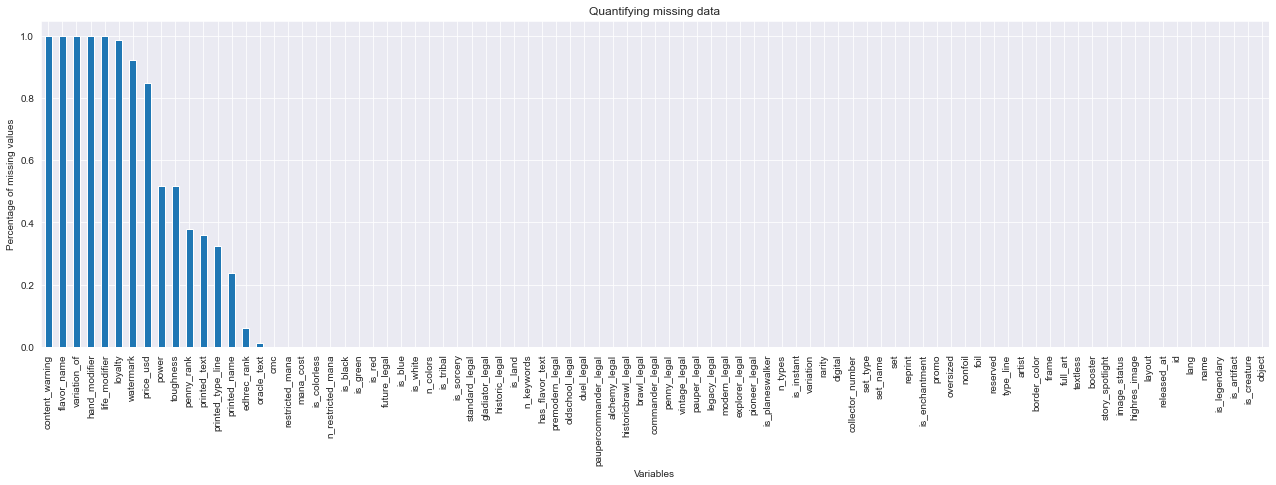

In [7]:
df_null_percentages = df.isnull().mean().sort_values(ascending=False)

df_null_percentages.plot.bar(figsize=(22,6))

plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data');

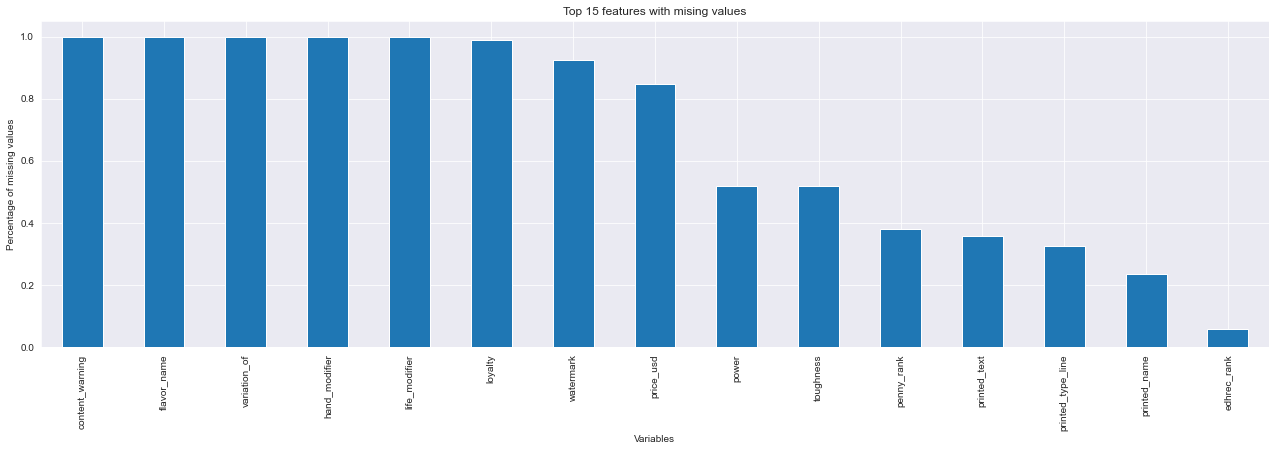

In [8]:
top_15_nulls = df_null_percentages.head(15)

top_15_nulls.plot.bar(figsize=(22,6))

plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Top 15 features with mising values');

### 3c. Determining cardinality in categorical variables

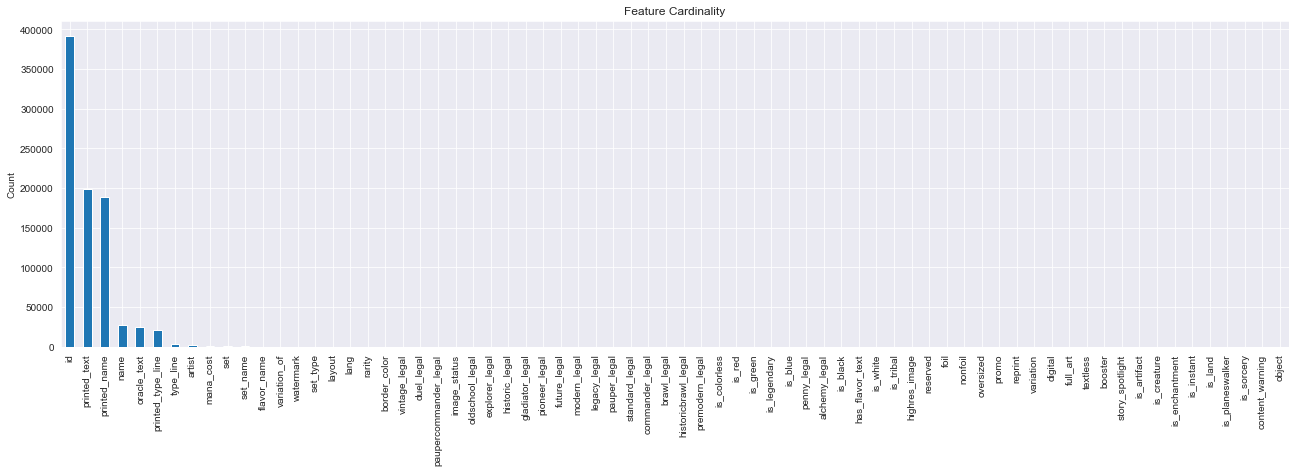

In [9]:
df[categorical].apply(lambda col: col.nunique()).sort_values(ascending=False).plot.bar(figsize = (22, 6))

plt.ylabel("Count")
plt.title("Feature Cardinality");

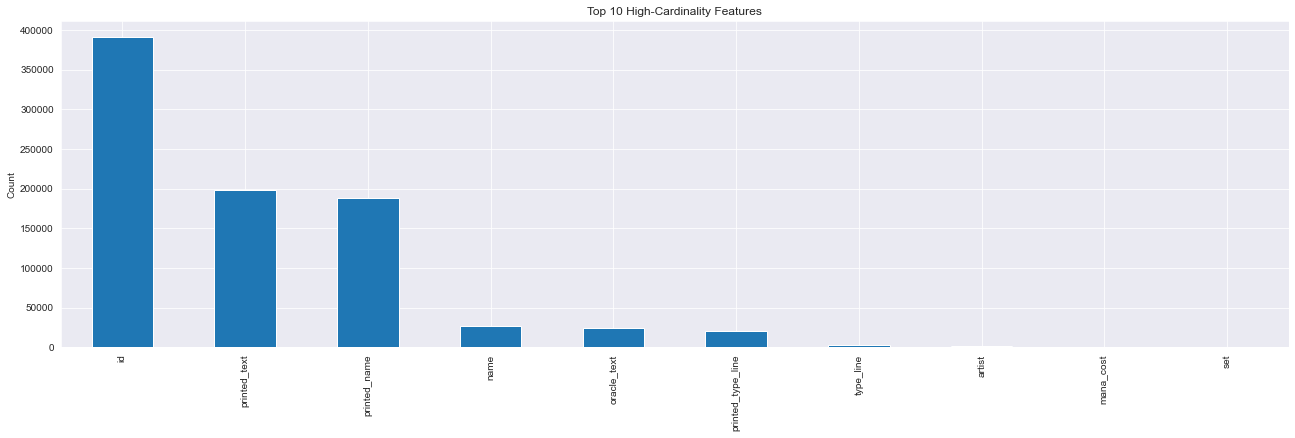

In [10]:
top_10_cardinality = df[categorical].apply(lambda col: col.nunique()).sort_values(ascending=False).head(10)

top_10_cardinality.plot.bar(figsize=(22, 6))

plt.ylabel("Count")
plt.title("Top 10 High-Cardinality Features");

### 3d. Pinpointing rare categories in categorical variables

##### "Typically, we consider a label to be rare when it appears in less than 5% or 1% of the population."
##### - Soledad Galli, Python Feature Engineering Cookbook

In [75]:
rare_value_dict = {}
rare_value_df = df[categorical].drop(columns=top_10_cardinality.index)

# Iterate through every feature in df and find rare values.

for col in rare_value_df.columns:
    value_counts = (
        df[col]
        .value_counts(normalize=True)
        .to_frame()
    )

    index = value_counts.index
    values = value_counts[col]

    for i in range(value_counts.shape[0]):
        if values.iloc[i] < 0.05:
            rare_value_dict[f"{col}.{index[i]}"] = round(values.iloc[i], 4) * 100

# Turn dict of rare_values into DataFrame

rare_value_frame = (
    pd.DataFrame
    .from_dict(rare_value_dict, orient="index", columns=["frequency"])
    .reset_index()
    .sort_values(by="frequency", ascending=False)
)

rare_value_frame[["feature", "rare_value"]] = rare_value_frame["index"].str.split(".", n=1, expand=True)
rare_value_frame = rare_value_frame[["index", "feature", "rare_value", "frequency"]]

# Create 'ideal' col, which will give us a comparison between current frequency and the ideal frequency
# considering an absolute simetry between values.

nunique_dict = {}

for col in df.drop(columns=top_10_cardinality.index):
    nunique_dict[col] = df[col].nunique()

rare_value_frame["ideal"] = rare_value_frame["feature"].apply(lambda feature: round(1 / nunique_dict[feature], 4) * 100)

# Drop rare values whose ideal frequency is less than 5%

rare_value_frame.drop(
    index=
    rare_value_frame[
        rare_value_frame["ideal"] < 5
    ].index
    , inplace=True
                      )

# Create freq_to_ideal_prop, which informs how much a value represents in relation to its ideal size.

rare_value_frame["freq_to_ideal_prop"] = round(rare_value_frame["frequency"] / rare_value_frame["ideal"] * 100, 2)

rare_value_frame.sort_values(by="freq_to_ideal_prop", ascending=False, inplace=True)

rare_value_frame.head(10)

,index,feature,rare_value,frequency,ideal,freq_to_ideal_prop
0,lang.ko,lang,ko,3.91,5.88,66.50
1124,oldschool_legal.legal,oldschool_legal,legal,2.75,25.00,11.00
7,layout.token,layout,token,0.44,5.00,8.80
8,layout.transform,layout,transform,0.42,5.00,8.40
853,border_color.borderless,border_color,borderless,1.24,20.00,6.20
1121,duel_legal.not_legal,duel_legal,not_legal,1.53,25.00,6.12
1113,vintage_legal.not_legal,vintage_legal,not_legal,1.51,25.00,6.04
9,layout.art_series,layout,art_series,0.30,5.00,6.00
28,nonfoil.False,nonfoil,False,2.71,50.00,5.42
30,promo.True,promo,True,2.54,50.00,5.08


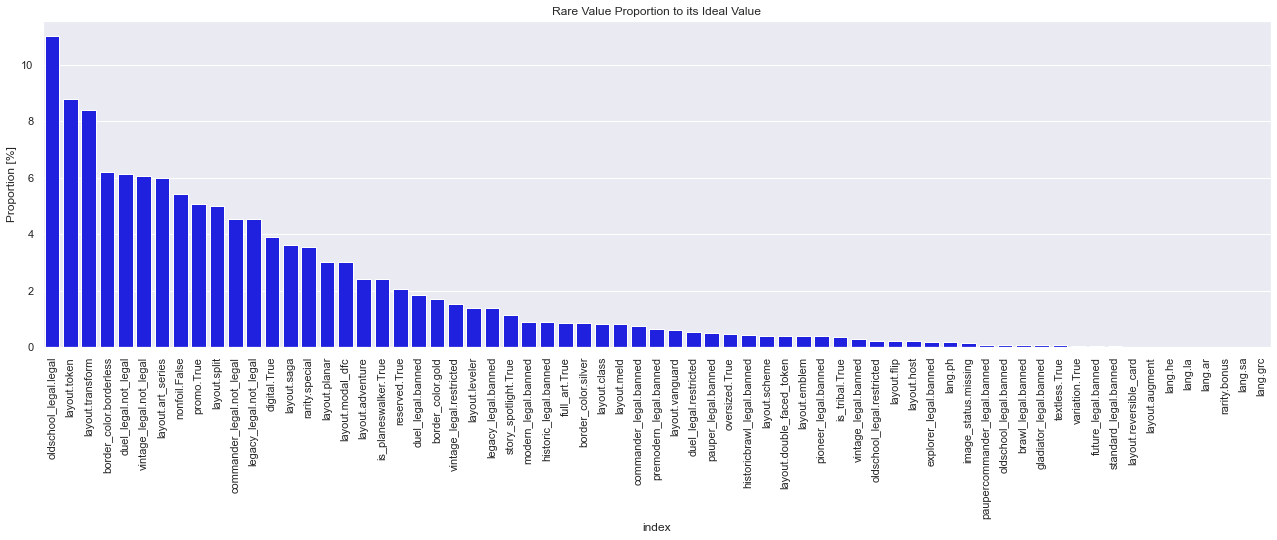

In [84]:
rare_values_plot = sns.barplot(x="index", y="freq_to_ideal_prop", data=rare_value_frame.iloc[1:], color="blue")

rare_values_plot.set_xticklabels(labels=rare_value_frame["index"].iloc[1:], rotation=90)
plt.ylabel("Proportion [%]")
plt.title("Rare Value Proportion to its Ideal Value");

### 3e. Identifying a linear relationship

### 3f. Identifying a normal distribution

---
## 4. Combat Phase - Exploratory Data Analysis

In [13]:
round(df["price_usd"].describe(), 2)

count    59640.00
mean         5.76
std         80.06
min          0.01
25%          0.11
50%          0.23
75%          1.06
max       9999.00
Name: price_usd, dtype: float64

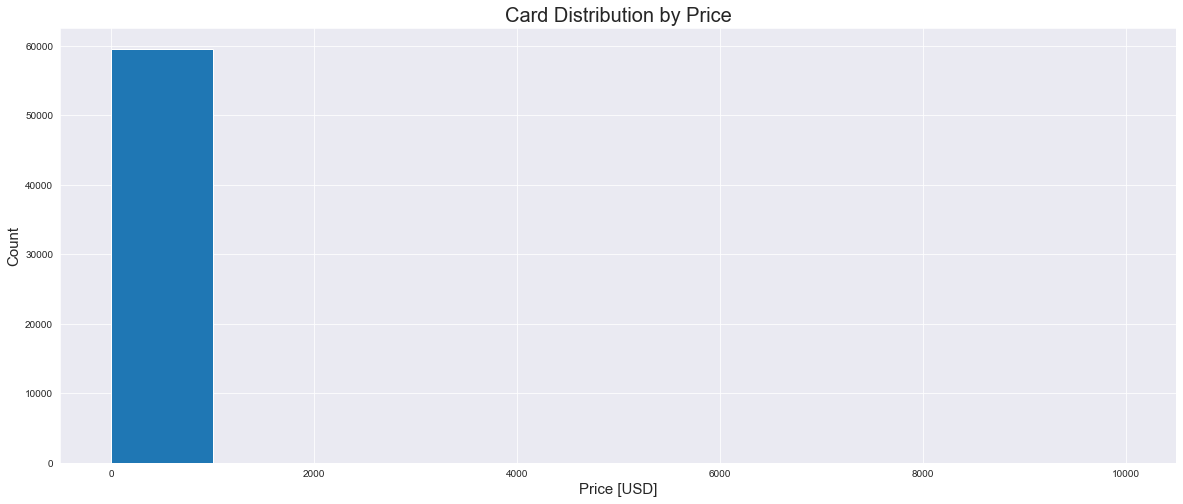

In [14]:
fig, ax = plt.subplots(figsize=(20, 8))

plt.hist(df["price_usd"])

plt.title("Card Distribution by Price",fontsize=20)
plt.xlabel("Price [USD]", fontsize=15)
plt.ylabel("Count", fontsize=15);

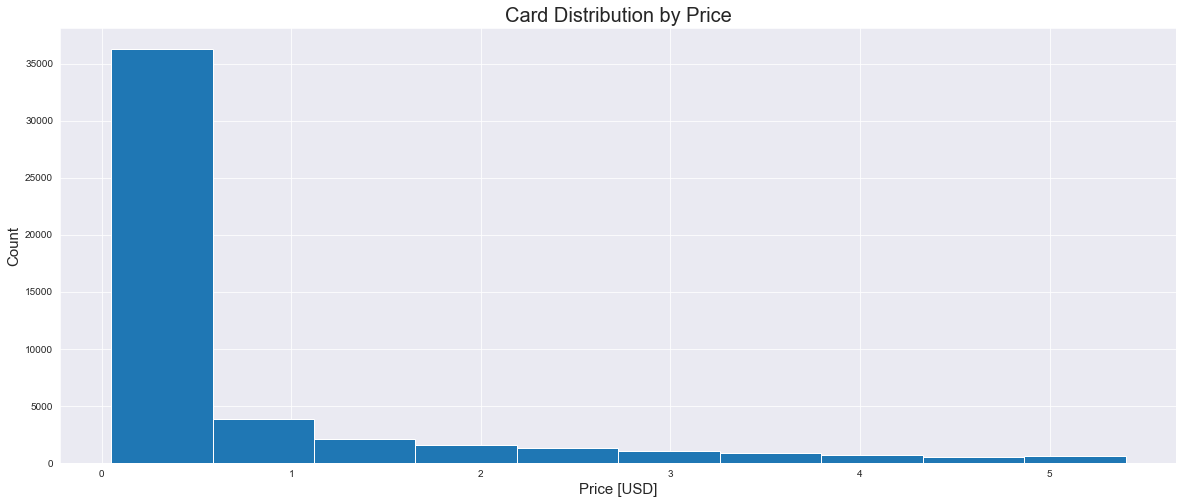

In [15]:
fig, ax = plt.subplots(figsize=(20, 8))

q1, q9 = df["price_usd"].quantile([0.1, 0.9])
mask = df["price_usd"].between(q1, q9)

plt.hist(df[mask]["price_usd"])

plt.title("Card Distribution by Price", fontsize=20)
plt.xlabel("Price [USD]",fontsize=15)
plt.ylabel("Count", fontsize=15);

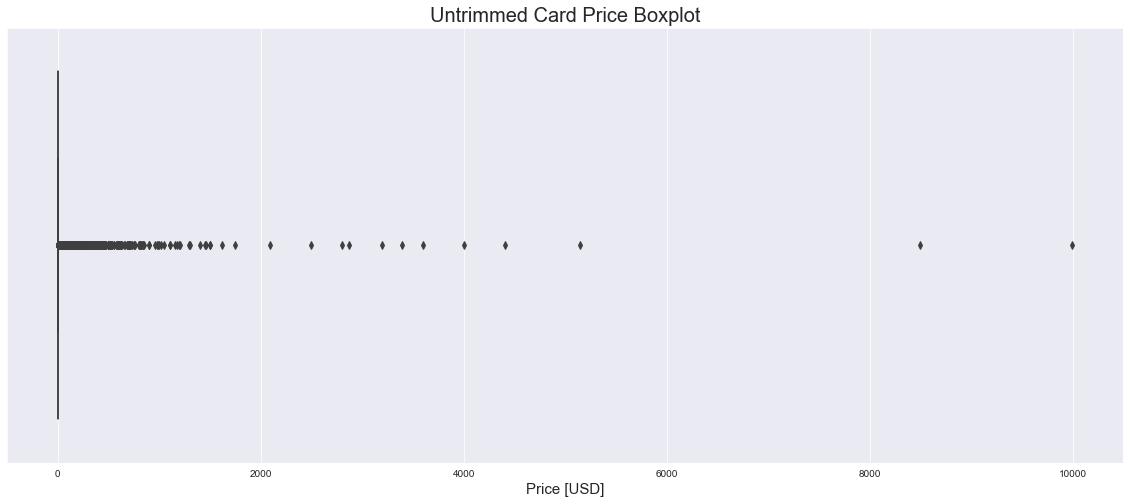

In [16]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.boxplot(x = "price_usd", data=df)

plt.title("Untrimmed Card Price Boxplot", fontsize=20)
plt.xlabel("Price [USD]", fontsize=15);

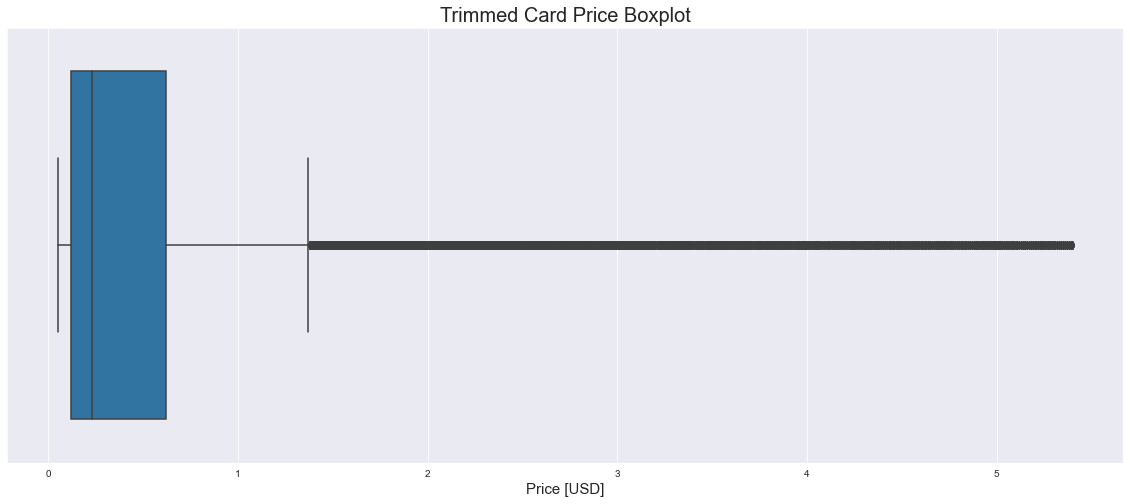

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))

q1, q9 = df["price_usd"].quantile([0.1, 0.9])
mask = df["price_usd"].between(q1, q9)

sns.boxplot(x = "price_usd", data = df[mask])

plt.title("Trimmed Card Price Boxplot", fontsize=20)
plt.xlabel("Price [USD]", fontsize=15);

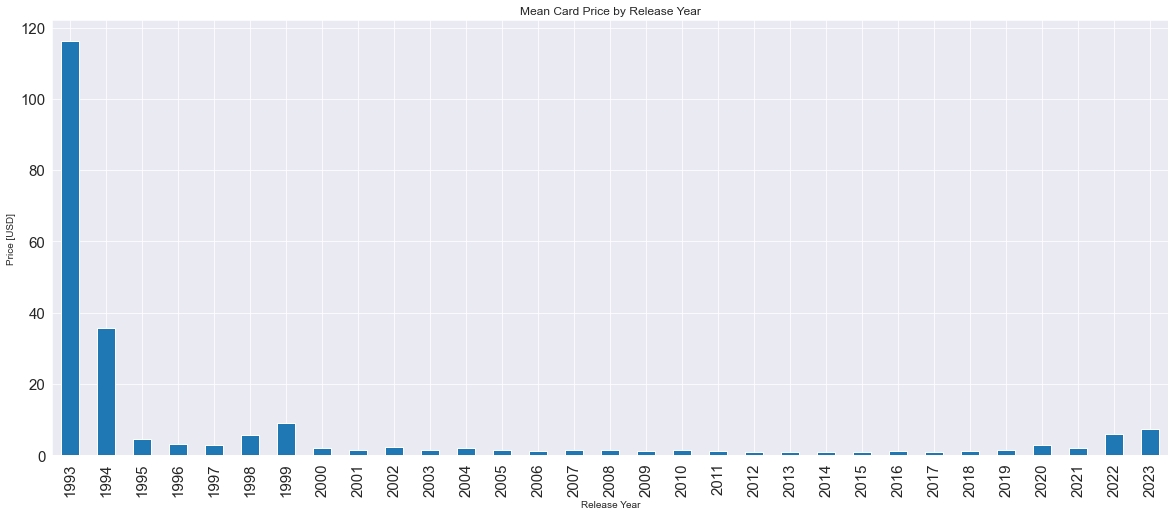

In [18]:
fig, ax = plt.subplots(figsize=(20, 8))

price_by_year = df.groupby(by=pd.DatetimeIndex(df['released_at']).year)

(price_by_year["price_usd"].mean()
 .plot(
    kind="bar",
    xlabel="Release Year",
    ylabel="Price [USD]",
    title="Mean Card Price by Release Year",
    fontsize=15
    )
);

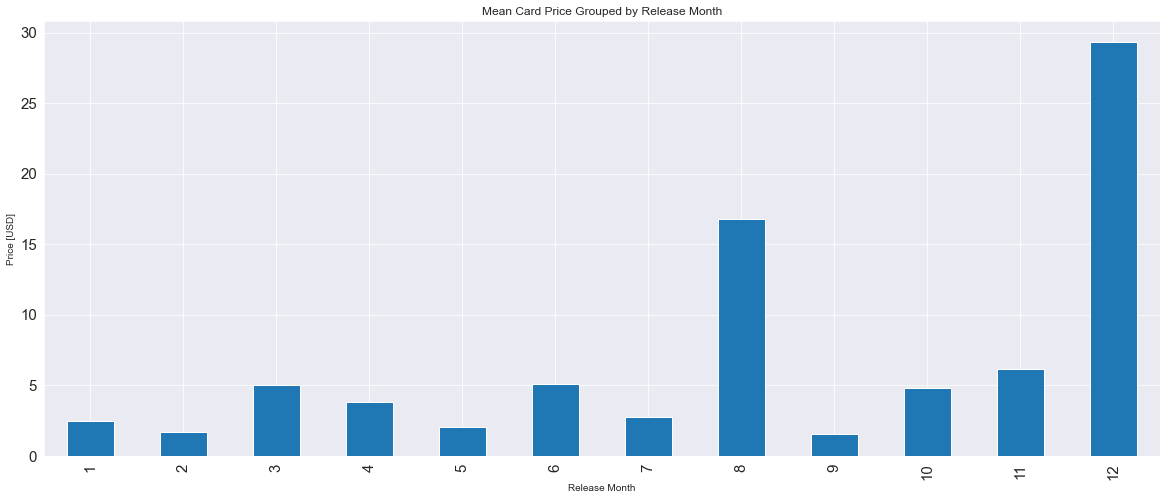

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))

price_by_year = df.groupby(by=pd.DatetimeIndex(df['released_at']).month)

(price_by_year["price_usd"].mean()
.plot(
    kind="bar",
    xlabel="Release Month",
    ylabel="Price [USD]",
    title="Mean Card Price Grouped by Release Month",
    fontsize=15
   )
);

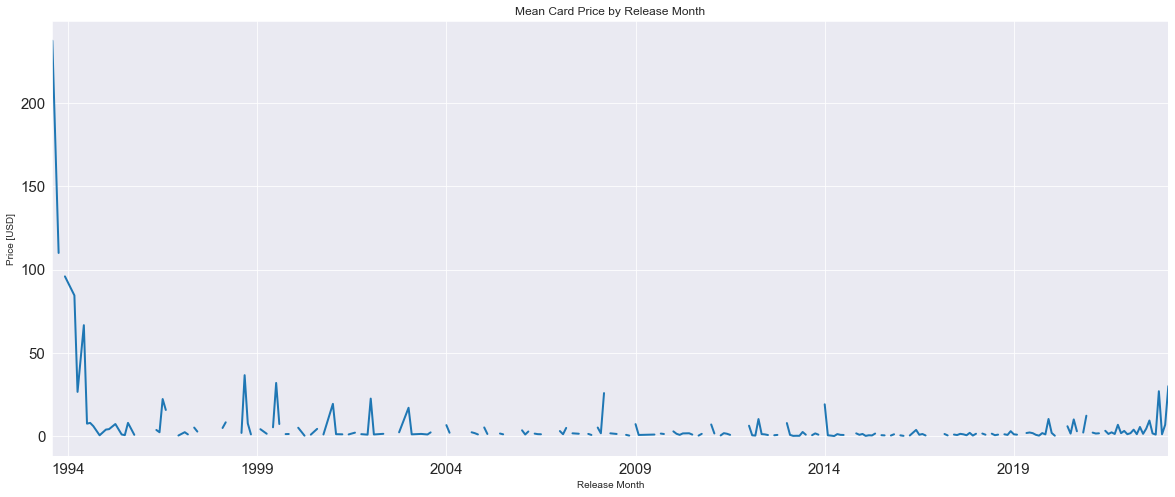

In [20]:
fig, ax = plt.subplots(figsize=(20, 8))

price_by_year = df.groupby(by=pd.DatetimeIndex(df['released_at']).to_period("M"))

(price_by_year["price_usd"].mean()
.plot(
    kind="line",
    xlabel="Release Month",
    ylabel="Price [USD]",
    title="Mean Card Price by Release Month",
    fontsize=15,
    linewidth=2
)
);

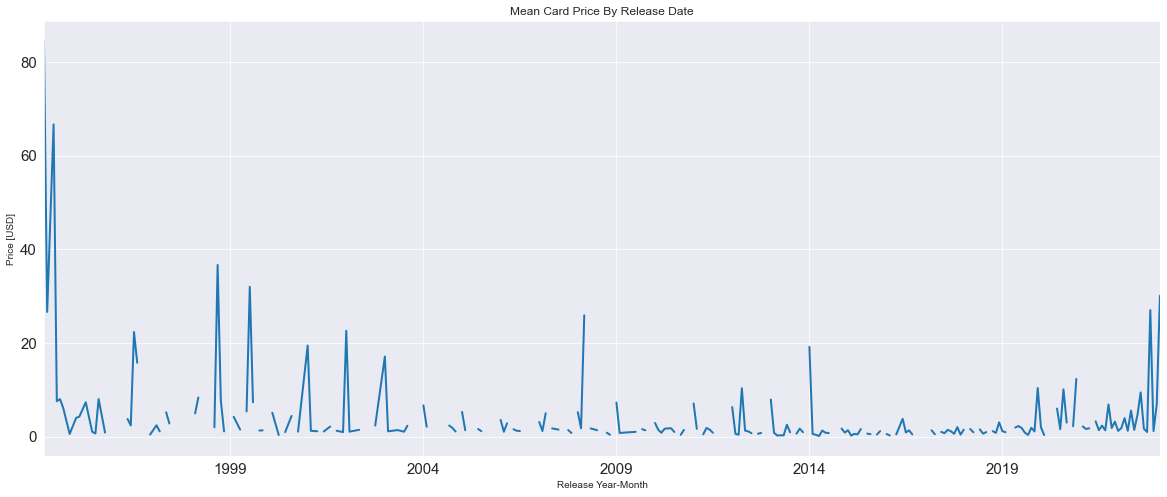

In [21]:
fig, ax = plt.subplots(figsize=(20, 8))

df_trimmed_by_date = df[pd.DatetimeIndex(df['released_at']).year >= 1994]

price_by_year = df_trimmed_by_date.groupby(
    by=(pd.DatetimeIndex(df_trimmed_by_date["released_at"])).to_period("M")
)

(price_by_year["price_usd"].mean()
.plot(
    kind="line",
    xlabel="Release Year-Month",
    ylabel="Price [USD]",
    title="Mean Card Price By Release Date",
    fontsize=15,
    linewidth=2
)
);

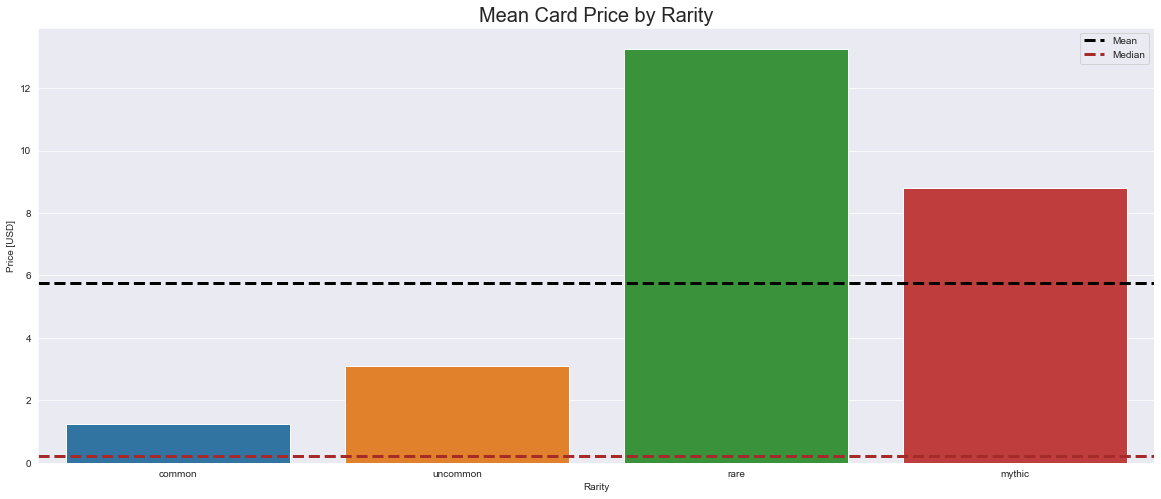

In [22]:
fig, ax = plt.subplots(figsize=(20, 8))

price_by_rarity = (
    df["price_usd"]
    .groupby(by = df["rarity"])
    .mean()
    .rename("mean_price")
    .to_frame()
    .reset_index()
)

sns.barplot(
    x="rarity",
    y="mean_price",
    data=price_by_rarity,
    order = {"0": "common", "1": "uncommon", "2": "rare", "3": "mythic"}.values()
)

plt.xlabel("Rarity")
plt.ylabel("Price [USD]")
plt.title("Mean Card Price by Rarity", fontsize=20)

plt.axhline(df["price_usd"].mean(), linestyle="--", linewidth=3, color="black", label="Mean")
plt.axhline(df["price_usd"].median(), linestyle="--", linewidth=3, color="brown", label="Median")
plt.legend();

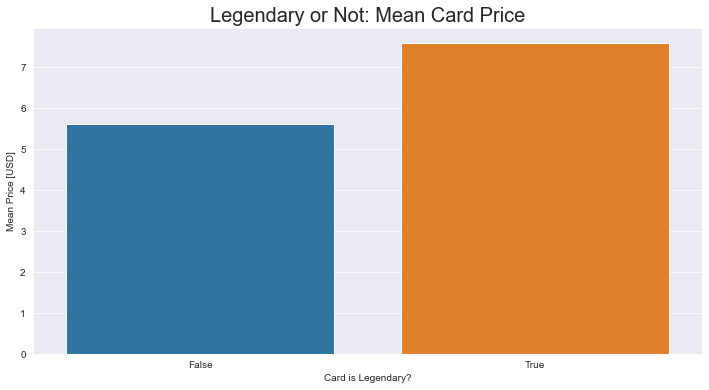

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

price_by_legendary = (
    df["price_usd"]
    .groupby(by = df["is_legendary"])
    .mean()
    .rename("mean_price")
    .to_frame()
    .reset_index()
)

sns.barplot(x="is_legendary", y="mean_price", data=price_by_legendary)

plt.title("Legendary or Not: Mean Card Price", fontsize=20)
plt.xlabel("Card is Legendary?")
plt.ylabel("Mean Price [USD]");

---

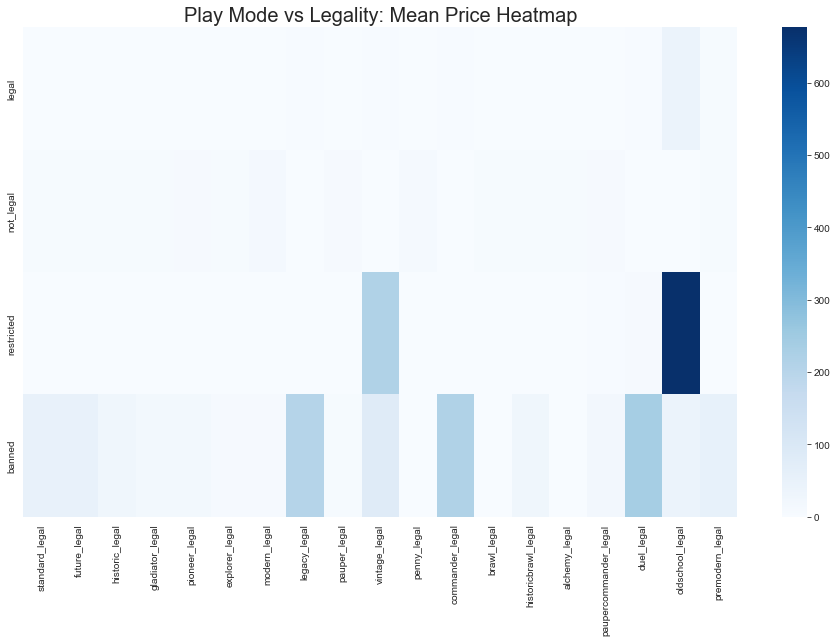

In [24]:
fig, ax = plt.subplots(figsize=(16, 9))

legalities_cols = [col for col in df.columns if "_legal" in col]
labels = ["legal", "not_legal", "restricted", "banned"]

legal = []
not_legal = []
restricted = []
banned = []

nested_list = [legal, not_legal, restricted, banned]

for col in legalities_cols:
    for list in range(len(nested_list)):
        nested_list[list].append(
            df[df[col] == labels[list]]
            ["price_usd"]
            .mean()
        )

mean_price_by_legality = pd.DataFrame(data=nested_list, index=labels, columns=legalities_cols, dtype=float).fillna(0)
mean_price_by_legality = round(mean_price_by_legality, 2)

sns.heatmap(mean_price_by_legality, cmap="Blues")

plt.title("Play Mode vs Legality: Mean Price Heatmap", fontsize=20);

<AxesSubplot:>

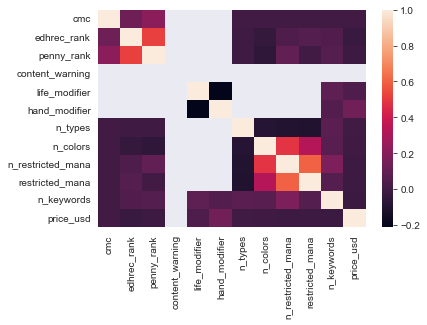

In [25]:
sns.heatmap(df.select_dtypes("number").corr())

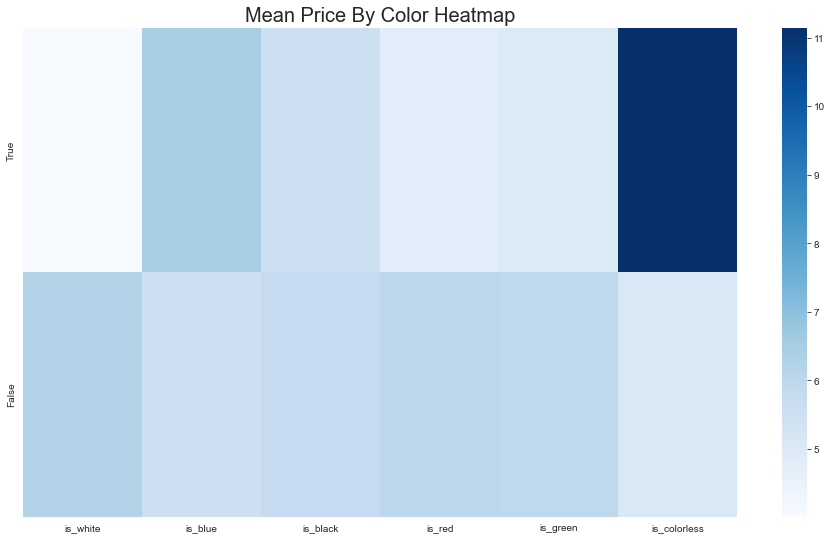

In [26]:
fig, ax = plt.subplots(figsize=(16, 9))

color_cols = ["is_white", "is_blue", "is_black", "is_red", "is_green", "is_colorless"]
bools = [True, False]

color = []
not_color = []

nested_list = [color, not_color]

for col in color_cols:
    for list in range(len(nested_list)):
        nested_list[list].append(
            df[df[col] == bools[list]]
            ["price_usd"]
            .mean()
        )

mean_price_by_color = pd.DataFrame(data=nested_list, index=bools, columns=color_cols, dtype=float).fillna(0)
mean_price_by_color = round(mean_price_by_color, 2)

sns.heatmap(mean_price_by_color, cmap="Blues")

plt.title("Mean Price By Color Heatmap", fontsize=20);

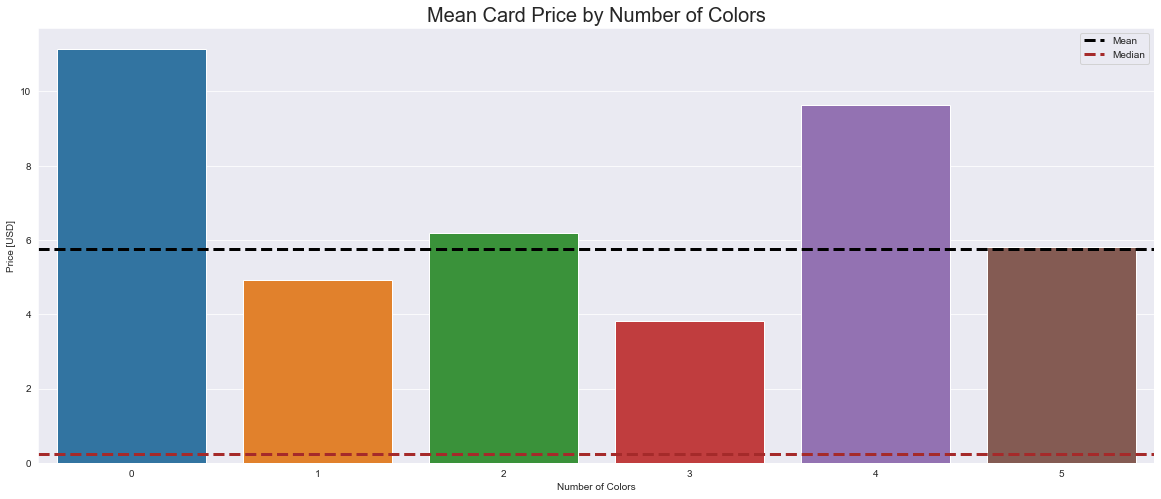

In [27]:
fig, ax = plt.subplots(figsize=(20, 8))

price_by_color = (
    df["price_usd"]
    .groupby(by = df["n_colors"])
    .mean()
    .rename("mean_price")
    .to_frame()
    .reset_index()
)

sns.barplot(
    x="n_colors",
    y="mean_price",
    data=price_by_color
)

plt.xlabel("Number of Colors")
plt.ylabel("Price [USD]")
plt.title("Mean Card Price by Number of Colors", fontsize=20)

plt.axhline(df["price_usd"].mean(), linestyle="--", linewidth=3, color="black", label="Mean")
plt.axhline(df["price_usd"].median(), linestyle="--", linewidth=3, color="brown", label="Median")
plt.legend();

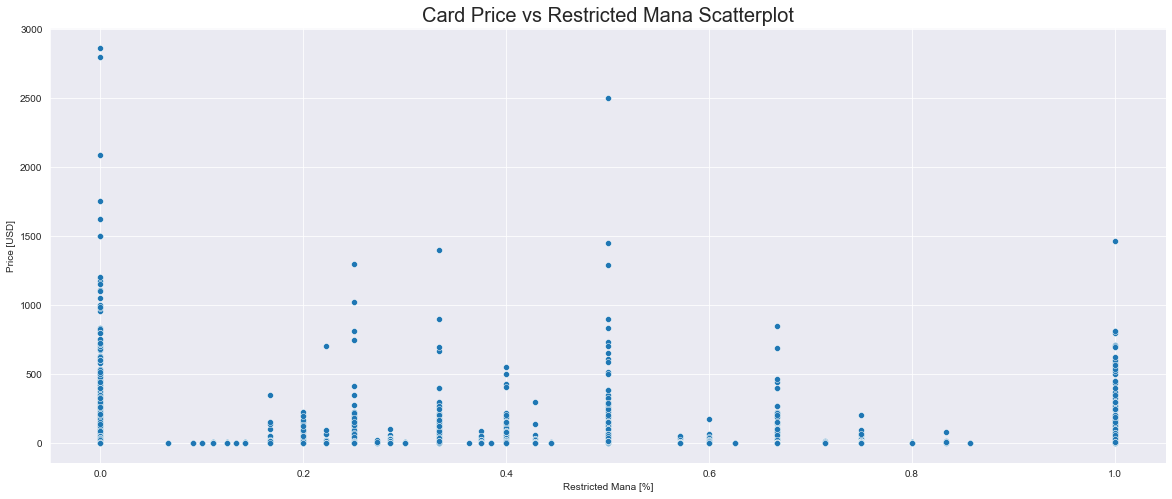

In [28]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.scatterplot(x="restricted_mana", y="price_usd", data=df[(df["price_usd"] < 3000) & (df["restricted_mana"] <= 1)])

plt.xlabel("Restricted Mana [%]")
plt.ylabel("Price [USD]")
plt.title("Card Price vs Restricted Mana Scatterplot", fontsize=20);

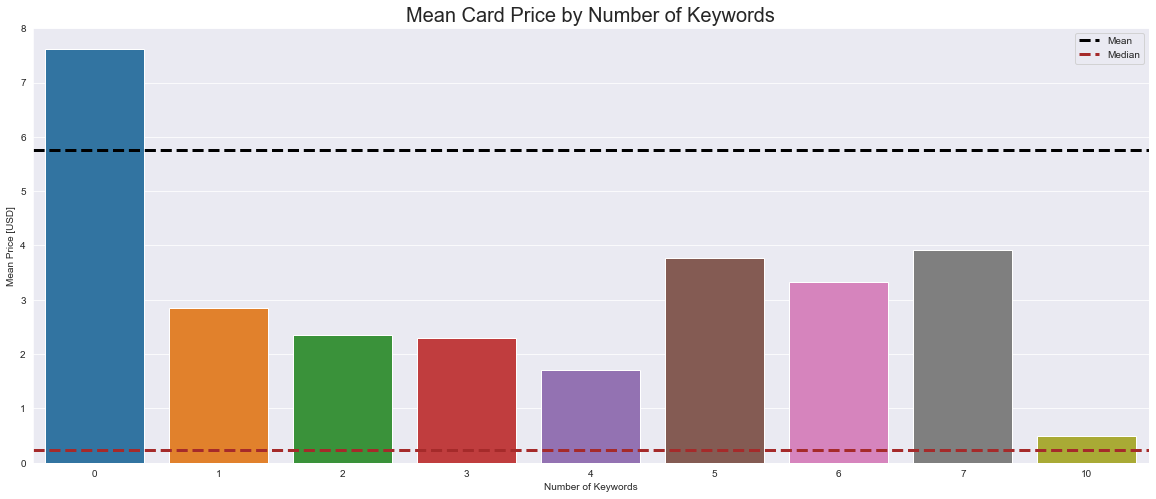

In [29]:
fig, ax = plt.subplots(figsize=(20, 8))

price_by_n_keyword = (
    df["price_usd"]
    .groupby(by = df["n_keywords"])
    .mean()
    .rename("mean_price")
    .to_frame()
    .reset_index()
)

sns.barplot(
    x="n_keywords",
    y="mean_price",
    data=price_by_n_keyword,
)

plt.xlabel("Number of Keywords")
plt.ylabel("Mean Price [USD]")
plt.title("Mean Card Price by Number of Keywords", fontsize=20)

plt.axhline(df["price_usd"].mean(), linestyle="--", linewidth=3, color="black", label="Mean")
plt.axhline(df["price_usd"].median(), linestyle="--", linewidth=3, color="brown", label="Median")
plt.legend();

---
## 5. Second Main Phase - Building, Training and Testing the Model

---
## 6. End Step - Communicating the Model

In [30]:
app = JupyterDash(__name__)

In [31]:
app.run_server(mode="external")

Dash app running on http://127.0.0.1:8050/


---
## 7. Cleanup Step - Conclusions